In [1]:
import numpy as np
np.random.seed(1720)  # for reproducibility
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

import os
import pathlib
import random

from sklearn import preprocessing 
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

In [2]:
# Here I set the size of image during the training as (224 x 224) as it is convenient for CNN layers
img_height = 224
img_width = 224
IMAGE_SIZE = (img_height,img_width)
# I set the batch size as 32 because the rumtime and performance are acceptable
BATCH_SIZE = 32
train_path = pathlib.Path("./chest_xray/train")
test_path = pathlib.Path("./chest_xray/test")
val_path = pathlib.Path("./chest_xray/val")

In [3]:
# Here I used the built-in method to do preprocessing for images
# I used the first 4 digit from my Student ID as the seed
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed = 1720,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    subset = "training")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed = 1720,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    # For here, due to the small size of given validation set, I split the training set for a new one.
    validation_split = 0.2,
    subset = "validation")
class_names = train_ds.class_names
print(class_names)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
['NORMAL', 'PNEUMONIA']


In [4]:
# From this we can see that the given validation set is too small.
nor = [len(os.listdir(str(train_path)+"/NORMAL")),len(os.listdir(str(test_path)+"/NORMAL")),len(os.listdir(str(val_path)+"/NORMAL"))]
pne = [len(os.listdir(str(train_path)+"/PNEUMONIA")),len(os.listdir(str(test_path)+"/PNEUMONIA")),len(os.listdir(str(val_path)+"/PNEUMONIA"))]

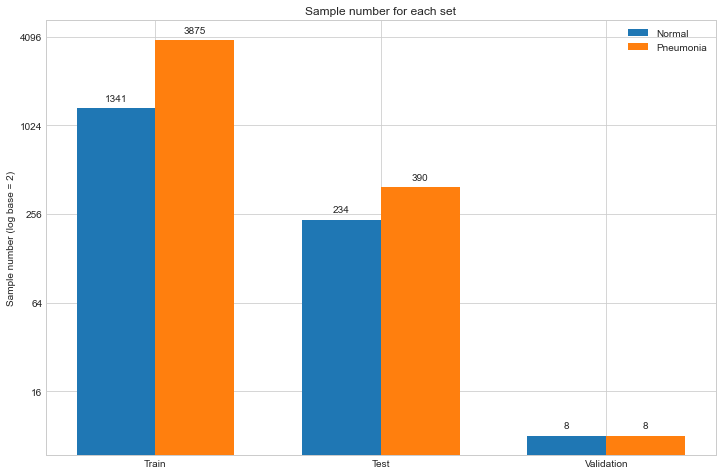

In [5]:
labels = ["Train", "Test", "Validation"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = plt.bar(x - width/2, nor, width, label='Normal')
rects2 = plt.bar(x + width/2, pne, width, label='Pneumonia')

plt.ylabel('Sample number (log base = 2)')
# Here I set the y-scale as log base on 2.
ax.set_yscale('log', base=2)
ax.yaxis.set_major_formatter(ScalarFormatter())
plt.title('Sample number for each set')
plt.xticks(x, labels)

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 
    
plt.legend()

plt.show()

In [6]:
# Here I shuffle the training set
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# The following comment are my code for training, if needed, you could run them as well.

In [8]:
# num_classes = 2
# model = Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

In [9]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [10]:
# model.summary()

In [11]:
# epochs=10
# history = model.fit(
#     train_ds,
#     validation_data = val_ds,
#     epochs=epochs
# )

In [12]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(16,8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [13]:
# Here I load my model from previou training
model = models.load_model("./model_weights/model_normalized.h5")

In [14]:
# Prepare for the output set
y_true = []
y_pred = []
# NORMAL : 0; PNEUMONIA : 1

In [15]:
test_path = "./chest_xray/test/NORMAL/"
files = os.listdir(test_path)
for file in files:
    # For every negative sample, save it in the true set first
    y_true.append(0)
    img = tf.keras.preprocessing.image.load_img(
        test_path+file, target_size=(img_height, img_width)
    )
    # Then load the img and use the model to predict it
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    # The score is in format [probability to be NORMAL, probability to be PNEUMONIA]
    score = tf.nn.softmax(predictions[0])
    y_pred.append(score[1])

In [16]:
test_path = "./chest_xray/test/PNEUMONIA/"
files = os.listdir(test_path)
count = 0
for file in files:
    # For every positive sample, save it in the true set first
    # The rest is similar to the previous cell
    y_true.append(1)
    img = tf.keras.preprocessing.image.load_img(
        test_path+file, target_size=(img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    y_pred.append(score[1])

In [17]:
# Here I get the ROC curve and AUC value
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
score = roc_auc_score(y_true, y_pred)

<Figure size 432x288 with 0 Axes>

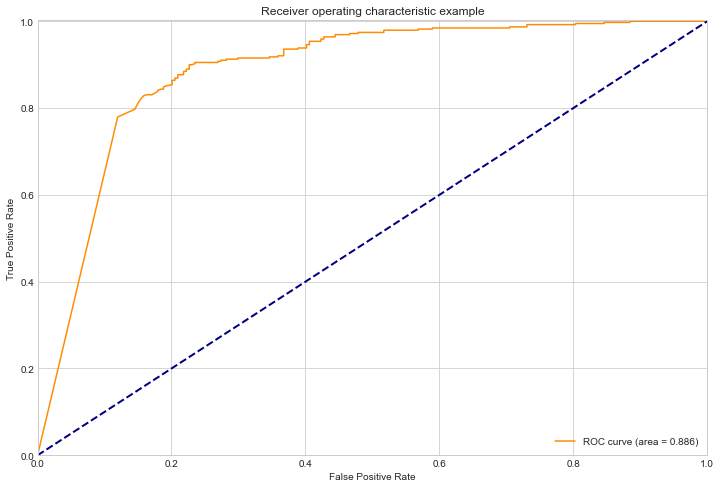

In [18]:
plt.figure()
lw = 2
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.3f)' % score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.002])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [19]:
# Here I delete the model for normalized traing data and re-generate a model for non-normalized training data
# The following is similar to the previous steps

In [20]:
# model.save('model_normalized.h5')  # creates a HDF5 file 'my_model.h5'
del model

In [21]:
# model = Sequential([
#   layers.experimental.preprocessing.Rescaling(scale=1.0,input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

In [22]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [23]:
# epochs=10 
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [24]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(16,8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [25]:
model = models.load_model("./model_weights/model_unnormalized.h5")

In [26]:
y_true = []
y_pred = []
# NORMAL : 0; PNEUMONIA : 1

In [27]:
test_path = "./chest_xray/test/NORMAL/"
files = os.listdir(test_path)
for file in files:
    y_true.append(0)
    img = tf.keras.preprocessing.image.load_img(
        test_path+file, target_size=(img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    y_pred.append(score[1])

In [28]:
test_path = "./chest_xray/test/PNEUMONIA/"
files = os.listdir(test_path)
count = 0
for file in files:
    y_true.append(1)
    img = tf.keras.preprocessing.image.load_img(
        test_path+file, target_size=(img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    y_pred.append(score[1])

In [29]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
score = roc_auc_score(y_true, y_pred)

<Figure size 432x288 with 0 Axes>

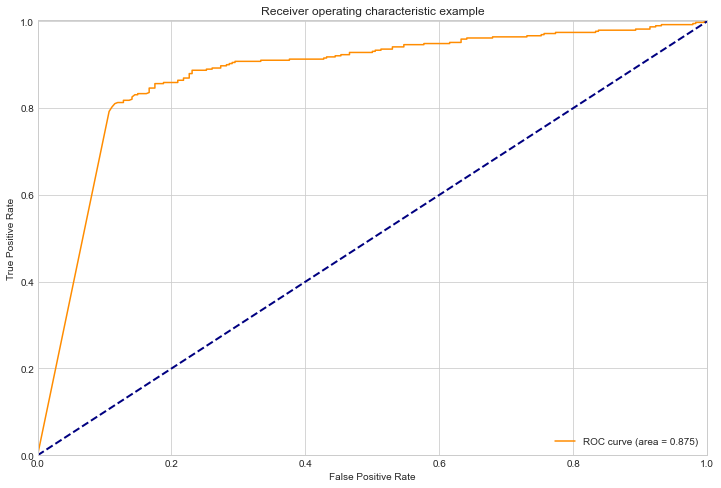

In [30]:
plt.figure()
lw = 2
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.3f)' % score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.002])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [31]:
# model.save('model_unnormalized.h5')  # creates a HDF5 file 'my_model.h5'
del model